In [1]:
!pip install kagglehub torch torchvision

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 31.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 48.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 38.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 24.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 6.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 108.9 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitli

In [5]:
import os
# Move it to the correct location
os.makedirs("/root/.kaggle", exist_ok=True)
!mv kaggle.json /root/.kaggle/kaggle.json
!chmod 600 /root/.kaggle/kaggle.json

In [7]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("splcher/animefacedataset")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/animefacedataset


In [8]:
import os
print("Files in path:")
print(os.listdir(path))


Files in path:
['images']


In [9]:
import os
from PIL import Image
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn

image_path = os.path.join(path, "images")  # Correct subfolder

# Step 2: Dataset class
class AnimeFaceDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.image_paths = [os.path.join(root_dir, fname)
                            for fname in os.listdir(root_dir)
                            if fname.lower().endswith(('.jpg', '.jpeg', '.png'))]
        self.transform = transform

        print(f"✅ Found {len(self.image_paths)} images in {self.root_dir}")

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img = Image.open(self.image_paths[idx]).convert("RGB")
        if self.transform:
            img = self.transform(img)
        return img

# Step 3: Transform
transform = transforms.Compose([
    transforms.Resize(64),
    transforms.CenterCrop(64),
    transforms.ToTensor(),
    transforms.Normalize([0.5]*3, [0.5]*3)
])

# Step 4: Load
dataset = AnimeFaceDataset(image_path, transform)
loader = DataLoader(dataset, batch_size=128, shuffle=True, num_workers=2)


✅ Found 63565 images in /kaggle/input/animefacedataset/images


In [10]:
class AnimeGenerator(nn.Module):
    def __init__(self, z_dim=128, img_channels=3):
        super().__init__()
        self.net = nn.Sequential(
            nn.ConvTranspose2d(z_dim, 1024, 4, 1, 0),  # 1x1 → 4x4
            nn.BatchNorm2d(1024),
            nn.ReLU(True),

            nn.ConvTranspose2d(1024, 512, 4, 2, 1),    # 4x4 → 8x8
            nn.BatchNorm2d(512),
            nn.ReLU(True),

            nn.ConvTranspose2d(512, 256, 4, 2, 1),     # 8x8 → 16x16
            nn.BatchNorm2d(256),
            nn.ReLU(True),

            nn.ConvTranspose2d(256, 128, 4, 2, 1),     # 16x16 → 32x32
            nn.BatchNorm2d(128),
            nn.ReLU(True),

            nn.ConvTranspose2d(128, img_channels, 4, 2, 1),  # 32x32 → 64x64
            nn.Tanh()
        )

    def forward(self, z):
        return self.net(z.view(z.size(0), z.size(1), 1, 1))


In [11]:
class AnimeDiscriminator(nn.Module):
    def __init__(self, img_channels=3):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv2d(img_channels, 128, 4, 2, 1),  # 64x64 → 32x32
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(128, 256, 4, 2, 1),           # 32x32 → 16x16
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(256, 512, 4, 2, 1),           # 16x16 → 8x8
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(512, 1024, 4, 2, 1),          # 8x8 → 4x4
            nn.BatchNorm2d(1024),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(1024, 1, 4, 1, 0),            # 4x4 → 1x1
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.net(x).view(-1, 1).squeeze(1)


Epoch [1/10] Batch [0/497] | Loss D: 1.2930 | Loss G: 3.4183
Epoch [1/10] Batch [50/497] | Loss D: 0.6910 | Loss G: 8.7646
Epoch [1/10] Batch [100/497] | Loss D: 1.6668 | Loss G: 5.6487
Epoch [1/10] Batch [150/497] | Loss D: 1.1924 | Loss G: 3.9216
Epoch [1/10] Batch [200/497] | Loss D: 1.6441 | Loss G: 9.8367
Epoch [1/10] Batch [250/497] | Loss D: 0.8015 | Loss G: 2.5585
Epoch [1/10] Batch [300/497] | Loss D: 0.7524 | Loss G: 3.6929
Epoch [1/10] Batch [350/497] | Loss D: 0.7940 | Loss G: 3.0972
Epoch [1/10] Batch [400/497] | Loss D: 1.4889 | Loss G: 7.2512
Epoch [1/10] Batch [450/497] | Loss D: 0.5876 | Loss G: 6.3519
Epoch [2/10] Batch [0/497] | Loss D: 1.3726 | Loss G: 3.4675
Epoch [2/10] Batch [50/497] | Loss D: 0.9598 | Loss G: 5.2855
Epoch [2/10] Batch [100/497] | Loss D: 0.7625 | Loss G: 7.8982
Epoch [2/10] Batch [150/497] | Loss D: 0.8987 | Loss G: 7.4357
Epoch [2/10] Batch [200/497] | Loss D: 1.9217 | Loss G: 4.7010
Epoch [2/10] Batch [250/497] | Loss D: 0.1275 | Loss G: 4.531

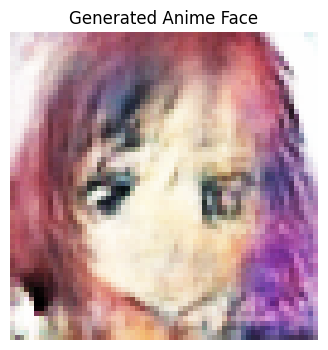

In [17]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import torchvision.utils as vutils

# Assuming AnimeGenerator and AnimeDiscriminator are already defined
# with AnimeGenerator(z_dim=128) and AnimeDiscriminator()

z_dim = 128
device = 'cuda' if torch.cuda.is_available() else 'cpu'

G = AnimeGenerator(z_dim=z_dim).to(device)
D = AnimeDiscriminator().to(device)

loss_fn = nn.BCELoss()
opt_G = torch.optim.Adam(G.parameters(), lr=0.0002, betas=(0.5, 0.999))
opt_D = torch.optim.Adam(D.parameters(), lr=0.0002, betas=(0.5, 0.999))

fixed_noise = torch.randn(1, z_dim, device=device)

# === Train loop ===
G.train()
D.train()
for epoch in range(5):
    for batch_idx, real_imgs in enumerate(loader):
        real_imgs = real_imgs.to(device)
        batch_size = real_imgs.size(0)

        # Labels
        real_labels = torch.ones(batch_size, device=device)
        fake_labels = torch.zeros(batch_size, device=device)

        # Discriminator update
        noise = torch.randn(batch_size, z_dim, device=device)
        fake_imgs = G(noise.view(batch_size, z_dim, 1, 1)).detach()

        D_real = D(real_imgs)
        D_fake = D(fake_imgs)

        loss_D_real = loss_fn(D_real, real_labels)
        loss_D_fake = loss_fn(D_fake, fake_labels)
        loss_D = loss_D_real + loss_D_fake

        opt_D.zero_grad()
        loss_D.backward()
        opt_D.step()

        # === Train Generator ===
        noise = torch.randn(batch_size, z_dim, device=device)
        fake_imgs = G(noise.view(batch_size, z_dim, 1, 1))
        D_fake = D(fake_imgs)
        loss_G = loss_fn(D_fake, real_labels)

        opt_G.zero_grad()
        loss_G.backward()
        opt_G.step()

        if batch_idx % 50 == 0:
            print(f"Epoch [{epoch+1}/10] Batch [{batch_idx}/{len(loader)}] | "
                  f"Loss D: {loss_D.item():.4f} | Loss G: {loss_G.item():.4f}")

# === Show 1 sample image ===
G.eval()
with torch.no_grad():
    sample_img = G(fixed_noise.view(1, z_dim, 1, 1)).detach().cpu()
    sample_img = vutils.make_grid(sample_img, normalize=True)
    plt.figure(figsize=(4, 4))
    plt.imshow(sample_img.permute(1, 2, 0))
    plt.title("Generated Anime Face")
    plt.axis("off")
    plt.show()
